***
<p align="right">
      <img src="https://www.dkrz.de/@@site-logo/dkrz.svg" width="12%" align="right" title="DKRZlogo" hspace="20">
      <img src="https://wr.informatik.uni-hamburg.de/_media/logo.png" width="12%" align="right" title="UHHLogo">
</p>
<div style="font-size: 20px" align="center"><b> Python Course for Geoscientists, 9-12 October 2023</b></div>
<div style="font-size: 15px" align="center">
    <b>see also <a href="https://gitlab.dkrz.de/pythoncourse/material">https://gitlab.dkrz.de/pythoncourse/material</a></b>
</div>

***

## Creating xarray datasets "from scratch" when the geospatial data are on an irregular grid

### Import libaries

In [1]:
import xarray as xr
import numpy as np

### Create some fake input data for the data variables and the coordinate variables

In [2]:
nlat, nlon = 10, 5
lats = np.linspace(-90., 90., nlat)
lons = np.linspace(-45., 45., nlon)

#-- create 2D latitude and longitude ndarrays based on meshgrid broadcasting, faking some  irregular grid.
lats2D, lons2D = np.meshgrid(lats, lons, indexing='ij')
lons2D         += 0.5 * lats2D                            #-- modify 2D lon array as a function of lat (optional)

#-- create some 2D ndarray  
mydata1     = np.arange(nlat * nlon).reshape(lons2D.shape)

look at lons2D

In [3]:
print(lons2D.shape)
print(lons2D)

(10, 5)
[[-90.  -67.5 -45.  -22.5   0. ]
 [-80.  -57.5 -35.  -12.5  10. ]
 [-70.  -47.5 -25.   -2.5  20. ]
 [-60.  -37.5 -15.    7.5  30. ]
 [-50.  -27.5  -5.   17.5  40. ]
 [-40.  -17.5   5.   27.5  50. ]
 [-30.   -7.5  15.   37.5  60. ]
 [-20.    2.5  25.   47.5  70. ]
 [-10.   12.5  35.   57.5  80. ]
 [  0.   22.5  45.   67.5  90. ]]


In [4]:
#xr.DataArray(data=mydata1).plot();

### create an xarray DataArray representing one data variable

In [5]:
#--create xarray DataArray with metadata for fake data with an irregular grid (metric coordinate system)
#  in this example, two coordinate variables are available to describe each dimension coordinate
#  latitude(rlat,rlon) in degrees_north
#  latitude2(rlat) in m
da1 = xr.DataArray(data=mydata1, 
                   dims=("rlat", "rlon"), 
                   coords={
                       "latitude":  (("rlat", "rlon"), lats2D, {'long_name': 'latitude', 'units': 'degrees_north'}), 
                       "longitude": (("rlat", "rlon"), lons2D, {'long_name': 'longitude', 'units': 'degrees_east'}),
                       "latitude2": (("rlat"), lats, {'long_name': 'distance to origin in y-direction', 'units': 'm'}),
                       "longitude2": (("rlon"), lons, {'long_name': 'distance to origin in x-direction', 'units': 'm'})}, 
                    attrs={'standard_name': 'carbon_flux', 'units': 'kg m-2 s-2'}
                  )
#-- create a new DataArray by inheriting the attributes, dims, coords from da1
da2 = da1.copy(data=mydata1**2)
#-- overwrite standardname inherited from da1
da2.attrs["standard_name"]= 'nitrogen_flux'         

### Convert the DataArrays into a DataSet

In [6]:
ds = xr.Dataset({'c_flux': da1, 'n_flux': da2})

In [7]:
ds

<xarray.Dataset>
Dimensions:     (rlat: 10, rlon: 5)
Coordinates:
    latitude    (rlat, rlon) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
    longitude   (rlat, rlon) float64 -90.0 -67.5 -45.0 -22.5 ... 45.0 67.5 90.0
    latitude2   (rlat) float64 -90.0 -70.0 -50.0 -30.0 ... 30.0 50.0 70.0 90.0
    longitude2  (rlon) float64 -45.0 -22.5 0.0 22.5 45.0
Dimensions without coordinates: rlat, rlon
Data variables:
    c_flux      (rlat, rlon) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
    n_flux      (rlat, rlon) int64 0 1 4 9 16 25 ... 2025 2116 2209 2304 2401

.... Much more descriptive information is needed that the data can be properly georeferenced and e.g. projected!  
.... This is even painful for advanced python users....

### It is much less pain if you open a netCDF file with xarray where the georeferencing is already CF compliant  

In [14]:
#!wget https://github.com/TUBklima/UC2Data/raw/master/tests/test_files/DS_example_multidim.nc

In [9]:
ds_already = xr.open_dataset("../data/DS_example_multidim.nc") 

In [10]:
ds_already

<xarray.Dataset>
Dimensions:  (time: 24, z: 20, x: 40, y: 50)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-17T01:00:00 ... 2017-01-18
  * z        (z) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 15.0 16.0 17.0 18.0 19.0
  * x        (x) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 35.0 36.0 37.0 38.0 39.0
  * y        (y) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
    E_UTM    (x) float64 ...
    N_UTM    (y) float64 ...
Data variables:
    crs      int32 ...
    vrs      int32 ...
    ta       (time, z, y, x) float32 ...
Attributes: (12/26)
    title:           Multidimensional data example
    data_content:    ta
    source:          model
    version:         1
    Conventions:     CF-1.7
    dependencies:    
    ...              ...
    origin_x:        385412.0
    origin_y:        5813054.0
    origin_lon:      13.313614301603115
    origin_lat:      52.45563123831611
    origin_z:        42.0
    rotation_angle:  0.0

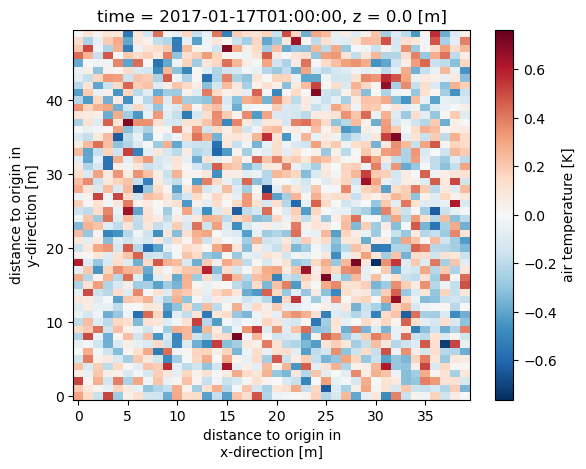

In [11]:
ds_already.isel(time=slice(0, 1),z=0).ta.plot();

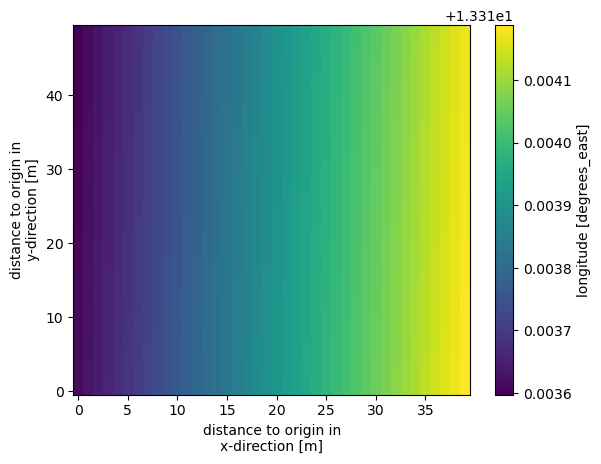

In [12]:
ds_already.lon.plot();

In [13]:
#ds['c_flux'].plot()

### Now you could e.g. use rioxarray, cartopy, xESMF, to reproject the data..even this is non-trivial